# SMS Classifier

Project realized using the FreeCodeCamp template.

## Importing useful libraries

In [2]:
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import re
from textblob import TextBlob

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

# nltk.download('stopwords')

## Fetch Data 

In [3]:
# get data files
TRAIN_DATA_URL = "https://raw.githubusercontent.com/beaucarnes/fcc_python_curriculum/master/sms/train-data.tsv"
TEST_DATA_URL = "https://raw.githubusercontent.com/beaucarnes/fcc_python_curriculum/master/sms/valid-data.tsv"

train_file_path = tf.keras.utils.get_file("train-data.tsv", TRAIN_DATA_URL)
test_file_path = tf.keras.utils.get_file("valid-data.tsv", TEST_DATA_URL)


In [4]:
train_data = pd.read_csv(train_file_path,sep="\t", names=['class', 'text'])
test_data = pd.read_csv(test_file_path,sep="\t", names=['class', 'text'])

In [5]:
train_data.head()

,class,text
0,ham,ahhhh...just woken up!had a bad dream about u ...
1,ham,you can never do nothing
2,ham,"now u sound like manky scouse boy steve,like! ..."
3,ham,mum say we wan to go then go... then she can s...
4,ham,never y lei... i v lazy... got wat? dat day ü ...


In [6]:
test_data.head()

,class,text
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


## PreProcess Data

- Tokenize sentences
- Lowered words
- Removed Stopwords
- Removed punctuations
- Stemmed words

In [7]:
def process_message(text):
    ps = PorterStemmer()
    
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    
    processed = [ps.stem(w.lower()) for w in tokenizer.tokenize(text) if w not in set(stopwords.words('english'))]
    
    return processed

print(test_data.iloc[0,1])
print(process_message(test_data.iloc[0,1]))


i am in hospital da. . i will return home in evening
['hospit', 'da', 'return', 'home', 'even']


## Data Analysis

Separated ham and spam categories

In [8]:
data = pd.merge(left=train_data, right=test_data, on=['class', 'text'], how='outer').drop_duplicates(['class', 'text']).reset_index(drop=True)


In [9]:
print(train_data.shape)
print(test_data.shape)
print(data.shape)
print(data.iloc[:10,])


(4179, 2)
(1392, 2)
(5156, 2)
  class                                               text
0   ham  ahhhh...just woken up!had a bad dream about u ...
1   ham                           you can never do nothing
2   ham  now u sound like manky scouse boy steve,like! ...
3   ham  mum say we wan to go then go... then she can s...
4   ham  never y lei... i v lazy... got wat? dat day ü ...
5   ham  in xam hall boy asked girl tell me the startin...
6   ham  genius what's up. how your brother. pls send h...
7   ham              they finally came to fix the ceiling.
8  spam  urgent! call 09066350750 from your landline. y...
9   ham  now that you have started dont stop. just pray...


In [10]:
ham_data = data.loc[data.iloc[:,0] == 'ham']

ham_proc_data = ham_data.iloc[:,1].apply(process_message)

vocabulary_ham = [inner for outer in ham_proc_data.to_list() for inner in outer]

freq_ham = nltk.FreqDist(vocabulary_ham)
print(freq_ham.most_common(10))

[('u', 926), ('go', 408), ('get', 354), ('2', 306), ('gt', 288), ('lt', 287), ('come', 279), ('ok', 256), ('call', 239), ('like', 238)]


In [11]:
spam_data = data.loc[data.iloc[:,0] == 'spam']

spam_proc_data = spam_data.iloc[:,1].apply(process_message)

vocabulary_spam = [inner for outer in spam_proc_data.to_list() for inner in outer]

freq_spam = nltk.FreqDist(vocabulary_spam)
print(freq_spam.most_common(10))

[('call', 325), ('free', 190), ('2', 184), ('u', 145), ('txt', 143), ('text', 128), ('ur', 119), ('mobil', 114), ('4', 112), ('stop', 111)]


### Get Subjectivity, Polarity and calculate the Sentiment for every sentence

In [12]:
# how subjective or opinionated the text is; a score of 0 is fact, and a score of +1 is very much an opinion
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# how positive or negative the text is;
def getPolarity(text):
    return TextBlob(text).sentiment.polarity


spam_info = {'Subjectivity':[], 'Polarity':[], 'Sentiment': []} 
ham_info = {'Subjectivity':[], 'Polarity':[], 'Sentiment': []} 

concat_pro_spam = spam_proc_data.str.join(" ").to_list()
concat_pro_ham = ham_proc_data.str.join(" ").to_list()

for i in range(len(concat_pro_ham)):
    sentiment = getPolarity(concat_pro_ham[i])
    ham_info['Subjectivity'].append(getSubjectivity(concat_pro_ham[i]))
    ham_info['Polarity'].append(sentiment)
    
    if sentiment == 0:
        ham_info['Sentiment'].append('Neutral')
    elif sentiment > 0:
        ham_info['Sentiment'].append('Positive')
    else:
        ham_info['Sentiment'].append('Negative')

for i in range(len(concat_pro_spam)):
    sentiment = getPolarity(concat_pro_spam[i])
    spam_info['Subjectivity'].append(getSubjectivity(concat_pro_spam[i]))
    spam_info['Polarity'].append(sentiment)
    
    if sentiment == 0:
        spam_info['Sentiment'].append('Neutral')
    elif sentiment > 0:
        spam_info['Sentiment'].append('Positive')
    else:
        spam_info['Sentiment'].append('Negative')

    
spam_info = pd.DataFrame(spam_info) 
ham_info = pd.DataFrame(ham_info)

print("\nSpam Sentiments :")
print(spam_info.head())
print("\nHam Sentiments :")
print(ham_info.head())


Spam Sentiments :
   Subjectivity  Polarity Sentiment
0      0.000000  0.000000   Neutral
1      0.000000  0.000000   Neutral
2      0.000000  0.000000   Neutral
3      0.800000  0.400000  Positive
4      0.454545  0.136364  Positive

Ham Sentiments :
   Subjectivity  Polarity Sentiment
0       0.60119 -0.207143  Negative
1       0.00000  0.000000   Neutral
2       0.40000  0.400000  Positive
3       0.15000 -0.200000  Negative
4       0.00000  0.000000   Neutral


## Data Visualization

### Value counts for Ham and Spam

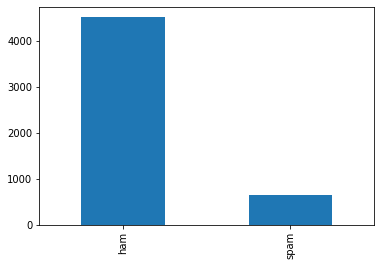

In [13]:
data['class'].value_counts().plot(kind = 'bar')

### WordCloud for Ham and Spam

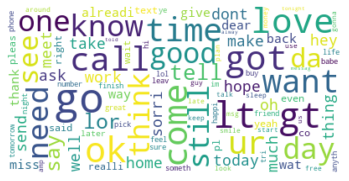

In [14]:
process_ham = ' '.join(vocabulary_ham)

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(process_ham)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

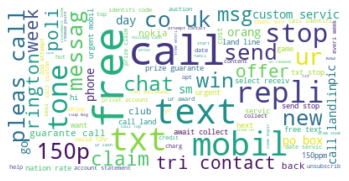

In [15]:
process_spam = ' '.join(vocabulary_spam)

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(process_spam)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Bar Plots of word Frequency for Ham and Spam

<BarContainer object of 20 artists>

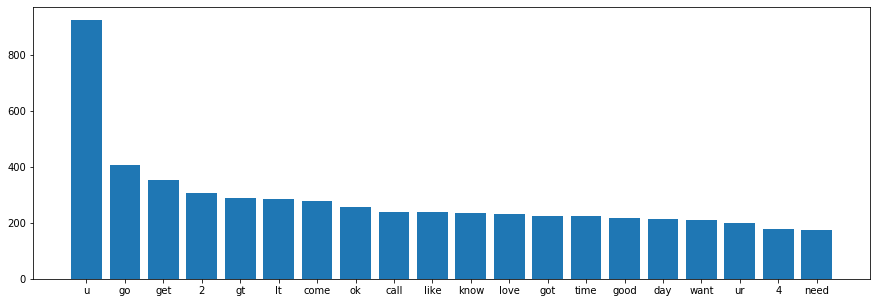

In [16]:
freq_ham_first = [a_tuple[0] for a_tuple in freq_ham.most_common(20)]
freq_ham_second = [a_tuple[1] for a_tuple in freq_ham.most_common(20)]

plt.figure(figsize=(15,5))
plt.bar(freq_ham_first, freq_ham_second)

<BarContainer object of 20 artists>

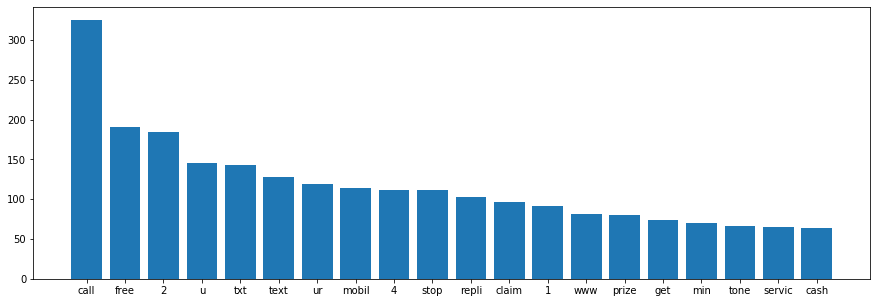

In [17]:
freq_spam_first = [a_tuple[0] for a_tuple in freq_spam.most_common(20)]
freq_spam_second = [a_tuple[1] for a_tuple in freq_spam.most_common(20)]

plt.figure(figsize=(15,5))
plt.bar(freq_spam_first, freq_spam_second)

### Value counts for Ham and Spam Sentiment text

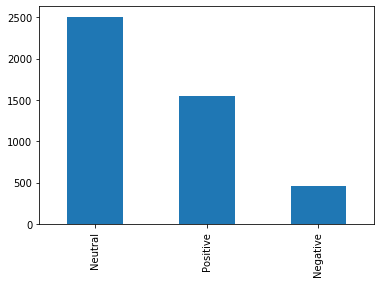

In [18]:
ham_info['Sentiment'].value_counts().plot(kind = 'bar')

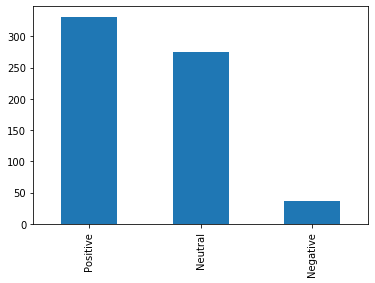

In [19]:
spam_info['Sentiment'].value_counts().plot(kind = 'bar')

## Data split

- Split into train and test sets
- Vectorized and Stemmed sentences

In [20]:
def stemmed_words(doc):
    return (ps.stem(w) for w in analyzer(doc))


In [21]:
analyzer = CountVectorizer().build_analyzer()

stem_analyzer = CountVectorizer(analyzer=process_message)

# Vectorize and Stem corpus
X_train = stem_analyzer.fit_transform(train_data.iloc[:,1]).toarray()
X_test = stem_analyzer.transform(test_data.iloc[:,1]).toarray()

# Is it a spam or not
y_train = pd.get_dummies(train_data.iloc[:,0]).iloc[:,1].values
y_test = pd.get_dummies(test_data.iloc[:,0]).iloc[:,1].values

In [22]:
print(X_train.shape)
print(X_test.shape)

(4179, 6232)
(1392, 6232)


## Fine Tuning Parameters
- For Multinomial Naïve Bayes 
    - Values for Alpha and Prior

In [23]:
tuned_parameters = [{'alpha': [0.01, 0.05, 0.1, 0.5, 1, 3, 5], 'fit_prior': [True, False]}]


clf = GridSearchCV(
    MultinomialNB(), tuned_parameters, scoring='precision'
)
clf.fit(X_train, y_train)

print("Best parameters :\n")
print(clf.best_params_)

print("\nGrid scores [Mean, Parameters] :\n")

for mean, params in zip(clf.cv_results_['mean_test_score'], clf.cv_results_['params']):
    print(params, " : ", round(mean,3))

    
y_true, y_pred = y_test, clf.predict(X_test)
print("\nClassification Report :\n")
print(classification_report(y_true, y_pred))


Best parameters :

{'alpha': 5, 'fit_prior': True}

Grid scores [Mean, Parameters] :

{'alpha': 0.01, 'fit_prior': True}  :  0.901
{'alpha': 0.01, 'fit_prior': False}  :  0.805
{'alpha': 0.05, 'fit_prior': True}  :  0.894
{'alpha': 0.05, 'fit_prior': False}  :  0.782
{'alpha': 0.1, 'fit_prior': True}  :  0.894
{'alpha': 0.1, 'fit_prior': False}  :  0.768
{'alpha': 0.5, 'fit_prior': True}  :  0.909
{'alpha': 0.5, 'fit_prior': False}  :  0.733
{'alpha': 1, 'fit_prior': True}  :  0.929
{'alpha': 1, 'fit_prior': False}  :  0.735
{'alpha': 3, 'fit_prior': True}  :  0.973
{'alpha': 3, 'fit_prior': False}  :  0.768
{'alpha': 5, 'fit_prior': True}  :  0.986
{'alpha': 5, 'fit_prior': False}  :  0.78

Classification Report :

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1205
           1       0.99      0.90      0.95       187

    accuracy                           0.99      1392
   macro avg       0.99      0.95      0.97      1392
we

### Defined best model parameters

In [24]:
model = MultinomialNB(alpha=5, fit_prior=True)
model.fit(X_train, y_train)

MultinomialNB(alpha=5, class_prior=None, fit_prior=True)

## Model Prediction

In [25]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
    
    stemmed_text = stem_analyzer.transform([pred_text]).toarray()
    
    result = "ham"
    
    if model.predict(stemmed_text) == 1:
        result = "spam"
    
    prediction = [pred_text, result]


    return (prediction)

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

['how are you doing today?', 'ham']


In [26]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


You passed the challenge. Great job!
